# Agentic RAG

- Author: [Heesun Moon](https://github.com/MoonHeesun)
- Design: [LeeYuChul](https://github.com/LeeYuChul)
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/02-Structures/06-Agentic-RAG.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/02-Structures/06-Agentic-RAG.ipynb)

## Overview

An **Agent** is useful when deciding whether to use a search tool. For more details about agents, refer to the [Agent](https://wikidocs.net/233782) page.

To implement a search agent, simply grant the `LLM` access to the search tool.

This can be integrated into [LangGraph](https://langchain-ai.github.io/langgraph/).

![langgraph-agentic-rag](./assets/06-langgraph-agentic-rag.png)

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Create a basic PDF-based Retrieval Chain](#create-a-basic-pdf-based-retrieval-chain)
- [Agent State](#agent-state)
- [Nodes and Edges](#nodes-and-edges)
- [Graph](#graph)
- [Execute the Graph](#execute-the-graph)

----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [3]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain",
        "langgraph",
        "langchain_core",
        "langchain_openai",
        "pdfplumber",
        "faiss-cpu",
    ],
    verbose=False,
    upgrade=False,
)


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "06-LangGraph-Agentic-RAG",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

**[Note]** This is not necessary if you've already set the required API keys in previous steps.

In [1]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Create a basic PDF-based Retrieval Chain

Here, we create a Retrieval Chain based on a PDF document. This is the Retrieval Chain with the simplest structure.

However, in LangGraph, Retirever and Chain are created separately. Only then can detailed processing be performed for each node.

**Reference**
- As this was covered in the previous tutorial, detailed explanation will be omitted.

In [ ]:
from rag.pdf import PDFRetrievalChain

# Load the PDF document
pdf = PDFRetrievalChain(
    ["data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf"]
).create_chain()

# Create retriever
pdf_retriever = pdf.retriever

# Create chain
pdf_chain = pdf.chain

Next, create the `retriever_tool` tool.

**[Note]**

The `document_prompt` is a prompt used to represent the retrieved document.

**Available Keys**

- `page_content`
- Keys in `metadata`: (e.g.) `source`, `page`

**Example Usage**

`"<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"`

In [7]:
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

# Create a retriever tool for querying the PDF document
retriever_tool = create_retriever_tool(
    pdf_retriever,
    "pdf_retriever",
    "Analyze and provide insights from the PDF file titled *A European Approach to Artificial Intelligence - A Policy Perspective*. This document explores AI trends, challenges, and opportunities across various sectors, offering valuable policy recommendations for sustainable AI development in Europe.",
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)

# Add the retriever tool to the tools list for agent use
tools = [retriever_tool]

## Agent State

We will define the graph.

Each node is passed a `state` object. The state consists of a list of `messages` .

Each node in the graph adds content to this list.

In [8]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


# Defines agent state and manages messages
class AgentState(TypedDict):
    # Manages the sequence of messages using the add_messages reducer function
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Nodes and Edges

An agent-based RAG graph can be structured as follows:

- `State` is a collection of messages.  
- Each `node` updates (adds to) the state.  
- `Conditional edges` determine the next node to visit.

Now, let's create a simple **Grader**.

In [19]:
from typing import Literal
from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


# Define the data model
class grade(BaseModel):
    """A binary score for relevance checks"""

    binary_score: str = Field(
        description="Response 'yes' if the document is relevant to the question or 'no' if it is not."
    )


def grade_documents(state) -> Literal["generate", "rewrite"]:
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

    # Set up LLM for structured output
    llm_with_tool = model.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    chain = prompt | llm_with_tool

    # Extract messages from the current state
    messages = state["messages"]

    # Get the most recent message
    last_message = messages[-1]

    # Extract the original question
    question = messages[0].content

    retrieved_docs = last_message.content

    # Perform relevance evaluation
    scored_result = chain.invoke({"question": question, "context": retrieved_docs})

    # Extract relevance status
    score = scored_result.binary_score

    if score == "yes":
        print("==== [DECISION: DOCS RELEVANT] ====")
        return "generate"

    else:
        print("==== [DECISION: DOCS NOT RELEVANT] ====")
        print(score)
        return "rewrite"


def agent(state):
    messages = state["messages"]

    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")

    # Bind the retriever tool
    model = model.bind_tools(tools)

    # Generate agent response
    response = model.invoke(messages)

    # Returns as a list since it is appended to the existing list
    return {"messages": [response]}


def rewrite(state):
    print("==== [QUERY REWRITE] ====")
    messages = state["messages"]

    question = messages[0].content

    # Create a prompt for question refinement
    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Refine the question using the LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    # Execute the Query-Transform chain
    response = model.invoke(msg)

    # Return the rewritten question
    return {"messages": [response]}


def generate(state):
    messages = state["messages"]

    question = messages[0].content

    docs = messages[-1].content

    # Load the RAG prompt template
    prompt = hub.pull("teddynote/rag-prompt")

    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    rag_chain = prompt | llm | StrOutputParser()

    response = rag_chain.invoke({"context": docs, "question": question})

    return {"messages": [response]}

## Graph

- Start with the `call_model` agent.  
- The agent decides whether to call a function.  
- If a function call is decided, an `action` is executed to invoke the tool (retriever).  
- The tool's output is added to the messages ( `state` ), and the agent is called again.  

In [20]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# Initialize the state graph workflow based on AgentState
workflow = StateGraph(AgentState)

# Define nodes
workflow.add_node("agent", agent)
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node(
    # Response generation node after checking relevant documents
    "generate",
    generate,
)

# Connect edges
workflow.add_edge(START, "agent")

# Add conditional edges for determining whether to perform retrieval
workflow.add_conditional_edges(
    "agent",
    # Evaluate agent decision
    tools_condition,
    {
        # Map condition outputs to graph nodes
        "tools": "retrieve",
        END: END,
    },
)

# Define edges for processing after action nodes are executed
workflow.add_conditional_edges(
    "retrieve",
    # Evaluate document quality
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile the graph
graph = workflow.compile(checkpointer=MemorySaver())

Visualize the compiled graph.

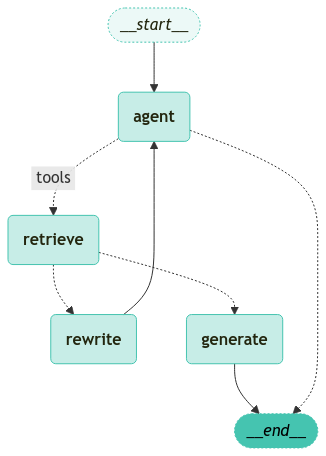

In [11]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(graph)

## Execute the Graph

Now, let's run the graph.

In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import stream_graph, invoke_graph, random_uuid

# Configure settings (maximum recursion limit, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# Define the input data structure, including a user query about the type of agent memory
inputs = {
    "messages": [
        (
            "user",
            "Where has the application of AI in healthcare been confined to so far?",
        ),
    ]
}

# Execute the graph
invoke_graph(graph, inputs, config)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_ntQvPrGfieUgf2wxlW6nwRUr)
 Call ID: call_ntQvPrGfieUgf2wxlW6nwRUr
  Args:
    query: application of AI in healthcare
==== [DECISION: DOCS RELEVANT] ====

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: pdf_retriever

<document><context>activities. So far, however, AI applications in healthcare have been potential. Specific healthcare training should be provided to data
confined to administrative tasks (i.e., Natural Language Processing scientists working in hospitals so that they can better understand</context><metadata><source>data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf</source><page>14</page></metadata></document>

<document><context>are great, as more use of AI 

c:\Users\user\dev\LangChain-OpenTutorial\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(



🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
The application of AI in healthcare has so far been confined primarily to administrative tasks, such as Natural Language Processing for extracting information from clinical notes and predictive scheduling. 

**Source**
- data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf (page 14)


In [14]:
# Graph Streaming Output
stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
The application of AI in healthcare has so far been confined primarily to administrative tasks. This includes the use of Natural Language Processing (NLP) for extracting information from clinical notes and predictive scheduling for managing appointments and visits.

**Source**
- data/A European Approach to Artificial Intelligence - A Policy Perspective.pdf (page 14)

The following are examples of questions where document retrieval is **unnecessary**.

In [15]:
# Examples of Questions Where Document Retrieval Is Unnecessary
inputs = {
    "messages": [
        ("user", "What is the capital of South Korea?"),
    ]
}

stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
The capital of South Korea is Seoul.

Below are some examples of questions where document retrieval is not possible.

As a result, a `GraphRecursionError` occurred during the continuous document retrieval process.

In [21]:
from langgraph.errors import GraphRecursionError

# Examples of Questions Where Document Retrieval Is Not Possible
inputs = {
    "messages": [
        ("user", "Tell me about TeddyNote's LangChain tutorial."),
    ]
}

try:
    stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [DECISION: DOCS NOT RELEVANT] ====
no
==== [QUERY REWRITE] ====

🔄 Node: rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
What are the key concepts and features covered in TeddyNote's LangChain tutorial, and how can they be applied in practical scenarios?
🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [DECISION: DOCS NOT RELEVANT] ====
no
==== [QUERY REWRITE] ====

🔄 Node: rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
What are the key concepts and features covered in TeddyNote's LangChain tutorial, and how can they be applied in practical scenarios?
🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [DECISION: DOCS NOT RELEVANT] ====
no
==== [QUERY REWRITE] ====

🔄 Node: rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
What are the key concepts and features covered in TeddyNote's LangChain tutorial, and how can they be applied in 

The next tutorial will cover how to resolve this issue.